In [1]:
import os
import sys

# # Set GPU or CPU; -1: CPU
# 0, 1, 2, 3: GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# disable message output from tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
sys.path.append("../src")
sys.path.append("../src/onetlib")

In [3]:
import pickle
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from lorenz_data.data_generator import data_generator_sde
from lorenz_data.data_generator import euler_sde
from lorenz_data.data_generator import euler_sde_net
from lorenz_data.data_generator import euler
import onsagernet as onet

## Data generation

The DNA data is 3-dimensional. For convenience, we denote the first, second and the third dimension by $X$,$Y$ and $Z$. We have $610$ DNA trajectories for training and $110$ DNA trajectories for testing. Each trajectory has length 1001, and the time step between the neighboring point is $\frac{0.5}{1000}$ . 

In [4]:
with open('DNA_data/DNA_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
X1_train = data['X1_train']
X2_train = data['X2_train']
X3_train = data['X3_train']
X1_test = data['X1_test']
X2_test = data['X2_test']
X3_test = data['X3_test']
print('X1_train shape:{}'.format(X1_train.shape))
print('X1_test shape:{}'.format(X1_test.shape))

X1_train shape:(610, 1001)
X1_test shape:(110, 1001)


In [6]:
X1_train = tf.reshape(X1_train,shape = (610,1001,1))
X2_train = tf.reshape(X2_train,shape = (610,1001,1))
X3_train = tf.reshape(X3_train,shape = (610,1001,1))
X1_test = tf.reshape(X1_test,shape = (110,1001,1))
X2_test = tf.reshape(X2_test,shape = (110,1001,1))
X3_test = tf.reshape(X3_test,shape = (110,1001,1))

Let's have a look at the 610 training trajectories first.

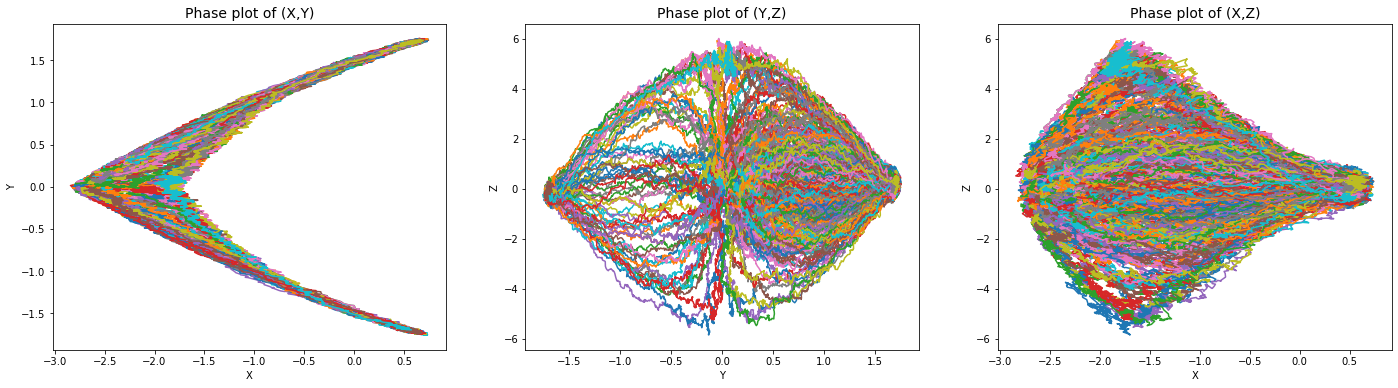

In [7]:
fig = plt.figure(figsize = (24,6))
axes = fig.add_subplot(1,3,1)

for i in range(610):
    axes.plot(X1_train[i,:,:],X2_train[i,:,:])
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_title('Phase plot of (X,Y)',fontsize = 14)

axes = fig.add_subplot(1,3,2)
for k in range(610):
    axes.plot(X2_train[k,:,:],X3_train[k,:,:])
axes.set_xlabel('Y')
axes.set_ylabel('Z')
axes.set_title('Phase plot of (Y,Z)',fontsize = 14)

axes = fig.add_subplot(1,3,3)
for k in range(610):
    axes.plot(X1_train[k,:,:],X3_train[k,:,:])
axes.set_xlabel('X')
axes.set_ylabel('Z')
axes.set_title('Phase plot of (X,Z)',fontsize = 14)
    
plt.show()

We choose the time step between the input variables and output variabels to be $\frac{0.5}{1000} \times 5$ .

In [8]:
step = 5
X_train = tf.concat([X1_train[:100,:1001-step,:],X2_train[:100,:1001-step,:],X3_train[:100,:1001-step,:]],-1)
X_train = tf.reshape(X_train,shape = (-1,3))
X_train.shape

TensorShape([99600, 3])

In [9]:
Y_train = tf.concat([X1_train[:100,step:,:],X2_train[:100,step:,:],X3_train[:100,step:,:]],-1)
Y_train = tf.reshape(Y_train,shape = (-1,3))
Y_train.shape

TensorShape([99600, 3])

In [10]:
X_val = tf.concat([X1_train[100:200,:1001-step,:],X2_train[100:200,:1001-step,:],X3_train[100:200,:1001-step,:]],-1)
X_val = tf.reshape(X_val,shape = (-1,3))
X_val.shape

TensorShape([99600, 3])

In [11]:
Y_val = tf.concat([X1_train[100:200,step:,:],X2_train[100:200,step:,:],X3_train[100:200,step:,:]],-1)
Y_val = tf.reshape(Y_val,shape = (-1,3))
Y_val.shape

TensorShape([99600, 3])

## Build OnsagerNet SDE model

In [12]:
beta = 0.1
alpha = 0.01
n_features = 3
delta_t = 0.5/1000*step

pot_layer_size = [16,16,4,4]
dc_layer_sizes = [16,16,4]
fc_layer_sizes = [16,16,4,4]
diffu_layer_sizes = [36,36,36,36,9,9,9,9]

In [13]:
# build Onsager net 
def build_onsager_net():
    # choose the activation function of FCPotentialNet to be tanh
    # tanh activation functiong works better on the DNA demo
    potential_net = onet.FCPotentialNet(beta = beta,
                                       layer_sizes = pot_layer_size,
                                       n_pot = n_features)
    dissconv_net = onet.FCDissConsNet(n_dim = n_features,
                                     layer_sizes = dc_layer_sizes)
    forcing_net = onet.FCForcingNet(n_dim = n_features,layer_sizes = fc_layer_sizes)
    onsager_net = onet.OnsagerNet(n_dim = n_features,
                                  potential_net = potential_net,
                                  dissconv_net = dissconv_net,
                                  forcing_net = forcing_net,
                                  alpha = alpha)
    
    DiffusitivityNet = onet.DiffusitivityNet(n_dim = n_features,layer_sizes = diffu_layer_sizes)
    
    inputs = tf.keras.Input((n_features,))
    outputs = tf.concat([inputs,onsager_net(inputs),DiffusitivityNet(inputs)],1)
    OnsagerNet = tf.keras.Model(inputs,outputs,name = 'onsager_rhs')
    return OnsagerNet

In [14]:
model = onet.SDEOnsagerNet(n_features = n_features,delta_t = delta_t, OnsagerNet = build_onsager_net())
model.build(input_shape = (None,n_features))
model.summary()

Model: "sde_onsager_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 onsager_rhs (Functional)    (None, 15)                6160      
                                                                 
Total params: 6,160
Trainable params: 6,160
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = onet.CustomEulerLoss(epsilon = 1e-4,n_features = n_features,delta_t = delta_t))

In [16]:
model.evaluate(X_train,Y_train)

3113/3113 [==============================] - 6s 2ms/step - loss: 1635906.7500


1635906.75

We have 110 DNA trajectories for test. Choose the data of the DNA trajectories at time 0 as initial conditions, we use our Neural networw to predict the whole trajectories only given the initial conditions. Since the time step of test trajectories is $\frac{0.5}{1000}$ , we choose the time step of our predicted trajectories to be also $\frac{0.5}{1000}$ .

We use our model to predict the trajectory before training.

In [17]:
trajectory_true = tf.concat([X1_test,X2_test,X3_test],-1)
trajectory_true = tf.cast(trajectory_true,tf.float64)
trajectory_initial = trajectory_true[:,0,:]

In [18]:
# 110 predicted trajectories
trajectory_pred = np.zeros(trajectory_true.shape)
trajectory_pred[:,0,:] = trajectory_initial


# 1000-step prediction
for i in range(1000):
    trajectory_pred[:,i+1,:] = model.predict(trajectory_pred[:,i,:],dt = 0.5/1000)
    

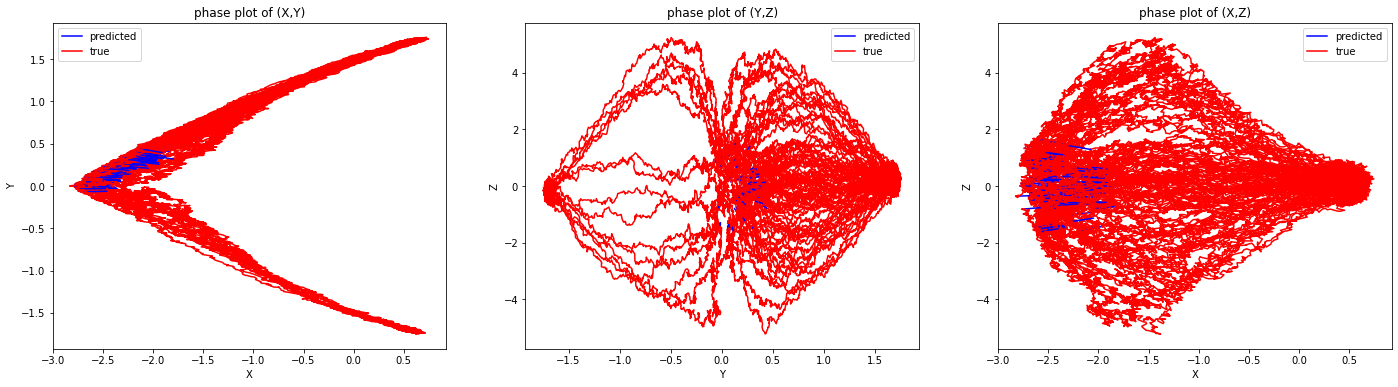

In [19]:
fig = plt.figure(figsize = (24,6))
axes = fig.add_subplot(1,3,1)
for i in range(110):
    axes.plot(trajectory_pred[i,:,0],trajectory_pred[i,:,1],'b')
    axes.plot(trajectory_true[i,:,0],trajectory_true[i,:,1],'r')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_title('phase plot of (X,Y)')
axes.legend(['predicted','true'])

axes = fig.add_subplot(1,3,2)
for i in range(110):
    axes.plot(trajectory_pred[i,:,1],trajectory_pred[i,:,2],'b')
    axes.plot(trajectory_true[i,:,1],trajectory_true[i,:,2],'r')
axes.set_xlabel('Y')
axes.set_ylabel('Z')
axes.set_title('phase plot of (Y,Z)')
axes.legend(['predicted','true'])

axes = fig.add_subplot(1,3,3)
for i in range(110):
    axes.plot(trajectory_pred[i,:,0],trajectory_pred[i,:,2],'b')
    axes.plot(trajectory_true[i,:,0],trajectory_true[i,:,2],'r')
axes.set_xlabel('X')
axes.set_ylabel('Z')
axes.set_title('phase plot of (X,Z)')
axes.legend(['predicted','true'])

plt.show()

We can see that the true trajectories and the predicted trajectories does not quite fit. 

Now let us train the model.

In [20]:
# set learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.4, patience = 2 , min_lr = 1e-8)
history = model.fit(x = X_train,
                    y = Y_train,
                    validation_data = (X_val,Y_val),
                    batch_size= 32,
                    epochs = 60,
                    callbacks = lr)

Epoch 1/60
3113/3113 [==============================] - 18s 5ms/step - loss: 1325.6427 - val_loss: -9.6723 - lr: 0.0100
Epoch 2/60
3113/3113 [==============================] - 18s 6ms/step - loss: -10.0845 - val_loss: -10.5648 - lr: 0.0100
Epoch 3/60
3113/3113 [==============================] - 18s 6ms/step - loss: -10.8390 - val_loss: -10.9685 - lr: 0.0100
Epoch 4/60
3113/3113 [==============================] - 16s 5ms/step - loss: -11.0067 - val_loss: -11.0746 - lr: 0.0100
Epoch 5/60
3113/3113 [==============================] - 19s 6ms/step - loss: -11.0795 - val_loss: -11.0942 - lr: 0.0100
Epoch 6/60
3113/3113 [==============================] - 16s 5ms/step - loss: -11.1419 - val_loss: -11.1605 - lr: 0.0100
Epoch 7/60
3113/3113 [==============================] - 15s 5ms/step - loss: -11.1865 - val_loss: -11.2661 - lr: 0.0100
Epoch 8/60
3113/3113 [==============================] - 16s 5ms/step - loss: -11.2348 - val_loss: -11.3001 - lr: 0.0100
Epoch 9/60
3113/3113 [==================

In [21]:
model.evaluate(X_train,Y_train)
model.evaluate(X_val,Y_val)

3113/3113 [==============================] - 5s 2ms/step - loss: -11.7569


-11.756906509399414

We use our model to predict the trajectory after training.

In [22]:
# 110 predicted trajectories
trajectory_pred = np.zeros(trajectory_true.shape)
trajectory_pred[:,0,:] = trajectory_initial


# 1000-step prediction
for i in range(1000):
    trajectory_pred[:,i+1,:] = model.predict(trajectory_pred[:,i,:],dt = 0.5/1000)
    

Let's have a look at the 110 true test trajectories and predicted trajectories.

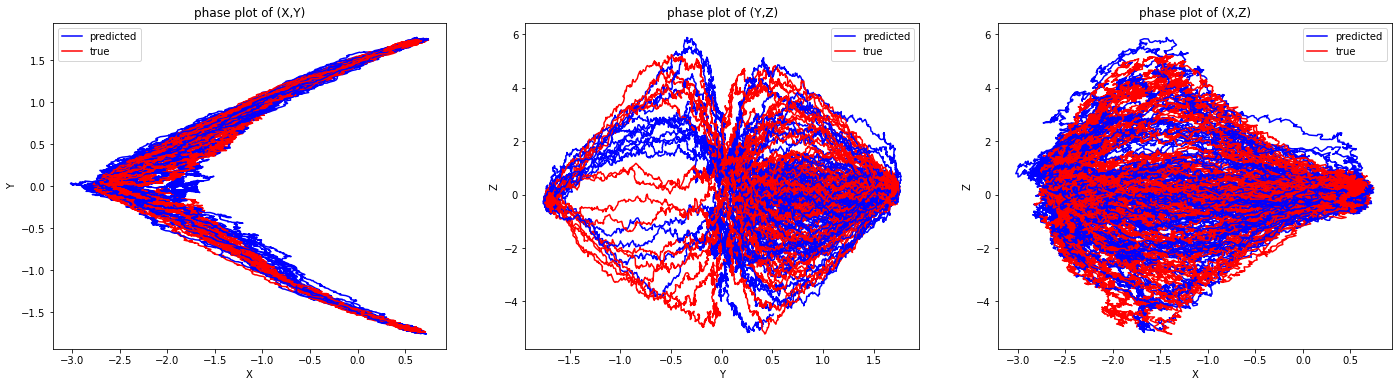

In [23]:
fig = plt.figure(figsize = (24,6))
axes = fig.add_subplot(1,3,1)
for i in range(110):
    axes.plot(trajectory_pred[i,:,0],trajectory_pred[i,:,1],'b')
    axes.plot(trajectory_true[i,:,0],trajectory_true[i,:,1],'r')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_title('phase plot of (X,Y)')
axes.legend(['predicted','true'])

axes = fig.add_subplot(1,3,2)
for i in range(110):
    axes.plot(trajectory_pred[i,:,1],trajectory_pred[i,:,2],'b')
    axes.plot(trajectory_true[i,:,1],trajectory_true[i,:,2],'r')
axes.set_xlabel('Y')
axes.set_ylabel('Z')
axes.set_title('phase plot of (Y,Z)')
axes.legend(['predicted','true'])

axes = fig.add_subplot(1,3,3)
for i in range(110):
    axes.plot(trajectory_pred[i,:,0],trajectory_pred[i,:,2],'b')
    axes.plot(trajectory_true[i,:,0],trajectory_true[i,:,2],'r')
axes.set_xlabel('X')
axes.set_ylabel('Z')
axes.set_title('phase plot of (X,Z)')
axes.legend(['predicted','true'])

plt.show()

We compute the mean of the 110 true test trajectoris as well as the 110 predicted trajectories and compare them. We also choose time $\frac{0.5}{1000}\times i, i = 0\cdots 10$. Then calculate the covariance matrix of the true and predicteed $X(t),Y(t),Z(t)$ at these time seperately.

In [24]:
true_mean = np.mean(trajectory_true,axis = 0)
pred_mean = np.mean(trajectory_pred,axis = 0)
print('true_mean shape:{}'.format(true_mean.shape))
print('pred_mean shape:{}'.format(pred_mean.shape))
print(np.max(np.abs(true_mean-pred_mean)))

true_mean shape:(1001, 3)
pred_mean shape:(1001, 3)
0.25381736248124376


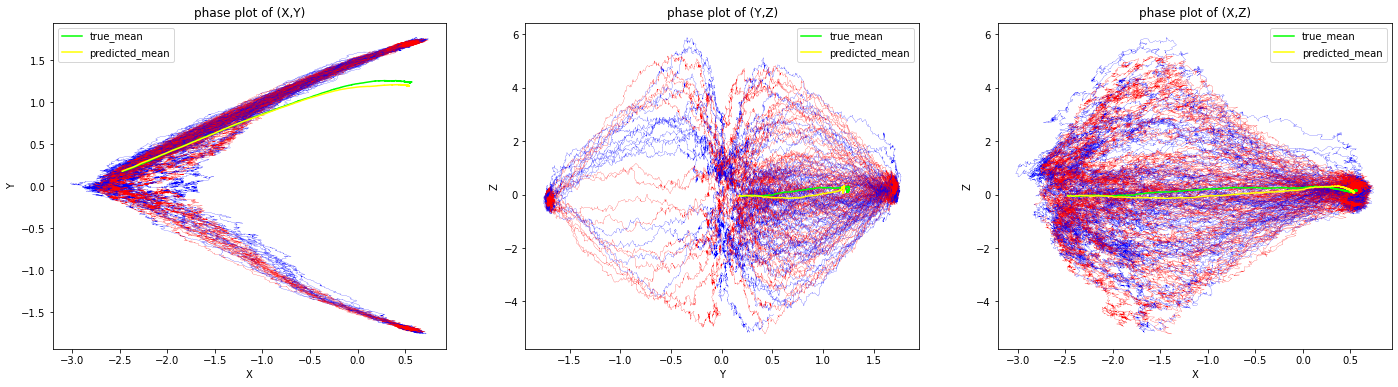

In [25]:
fig = plt.figure(figsize = (24,6))
axes = fig.add_subplot(1,3,1)
for i in range(110):
    axes.plot(trajectory_pred[i,:,0],trajectory_pred[i,:,1],'b',linewidth = 0.2)
    axes.plot(trajectory_true[i,:,0],trajectory_true[i,:,1],'r',linewidth = 0.2)

axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.plot(true_mean[:,0],true_mean[:,1],'lime',label = 'true_mean')
axes.plot(pred_mean[:,0],pred_mean[:,1],color = 'yellow',label = 'predicted_mean')
axes.legend()
axes.set_title('phase plot of (X,Y)')


axes = fig.add_subplot(1,3,2)
for i in range(110):
    axes.plot(trajectory_pred[i,:,1],trajectory_pred[i,:,2],'b',linewidth = 0.2)
    axes.plot(trajectory_true[i,:,1],trajectory_true[i,:,2],'r',linewidth = 0.2)
axes.set_xlabel('Y')
axes.set_ylabel('Z')
axes.plot(true_mean[:,1],true_mean[:,2],'lime',label = 'true_mean')
axes.plot(pred_mean[:,1],pred_mean[:,2],color = 'yellow',label = 'predicted_mean')
axes.set_title('phase plot of (Y,Z)')
axes.legend()

axes = fig.add_subplot(1,3,3)
for i in range(110):
    axes.plot(trajectory_pred[i,:,0],trajectory_pred[i,:,2],'b',linewidth = 0.2)
    axes.plot(trajectory_true[i,:,0],trajectory_true[i,:,2],'r',linewidth = 0.2)
axes.set_xlabel('X')
axes.set_ylabel('Z')
axes.plot(true_mean[:,0],true_mean[:,2],'lime',label = 'true_mean')
axes.plot(pred_mean[:,0],pred_mean[:,2],color = 'yellow',label = 'predicted_mean')
axes.set_title('phase plot of (X,Z)')
axes.legend()

plt.show()

In [26]:
index = np.arange(1,11,dtype = int)*100
sample_true = trajectory_true[:,0,:]
sample_true = tf.reshape(sample_true,shape = (-1,3,1))
sample_pred = trajectory_pred[:,0,:]
sample_pred = tf.reshape(sample_pred,shape = (-1,3,1))

for i in index:
    slice_true = trajectory_true[:,i,:]
    slice_true = tf.reshape(slice_true,shape = (-1,3,1))
    slice_pred = trajectory_pred[:,i,:]
    slice_pred = tf.reshape(slice_pred,shape = (-1,3,1))
    sample_true = tf.concat([sample_true,slice_true],-1)
    sample_pred = tf.concat([sample_pred,slice_pred],-1)
sample_true_X = sample_true[:,0,:]
sample_true_Y = sample_true[:,1,:]
sample_true_Z = sample_true[:,2,:]
sample_pred_X = sample_pred[:,0,:]
sample_pred_Y = sample_pred[:,1,:]
sample_pred_Z = sample_pred[:,2,:]

In [27]:
X_con_true = np.cov(tf.transpose(sample_true_X))
X_con_pred = np.cov(tf.transpose(sample_pred_X))

Y_con_true = np.cov(tf.transpose(sample_true_Y))
Y_con_pred = np.cov(tf.transpose(sample_pred_Y))

Z_con_true = np.cov(tf.transpose(sample_true_Z))
Z_con_pred = np.cov(tf.transpose(sample_pred_Z))


In [28]:
absolute_err_X = np.abs(X_con_true - X_con_pred)
absolute_err_Y = np.abs(Y_con_true - Y_con_pred)
absolute_err_Z = np.abs(Z_con_true - Z_con_pred)

print(np.max(absolute_err_X))
print(np.max(absolute_err_Y))
print(np.max(absolute_err_Z))


0.1281587647997181
0.22058628440255967
0.9537074427290579


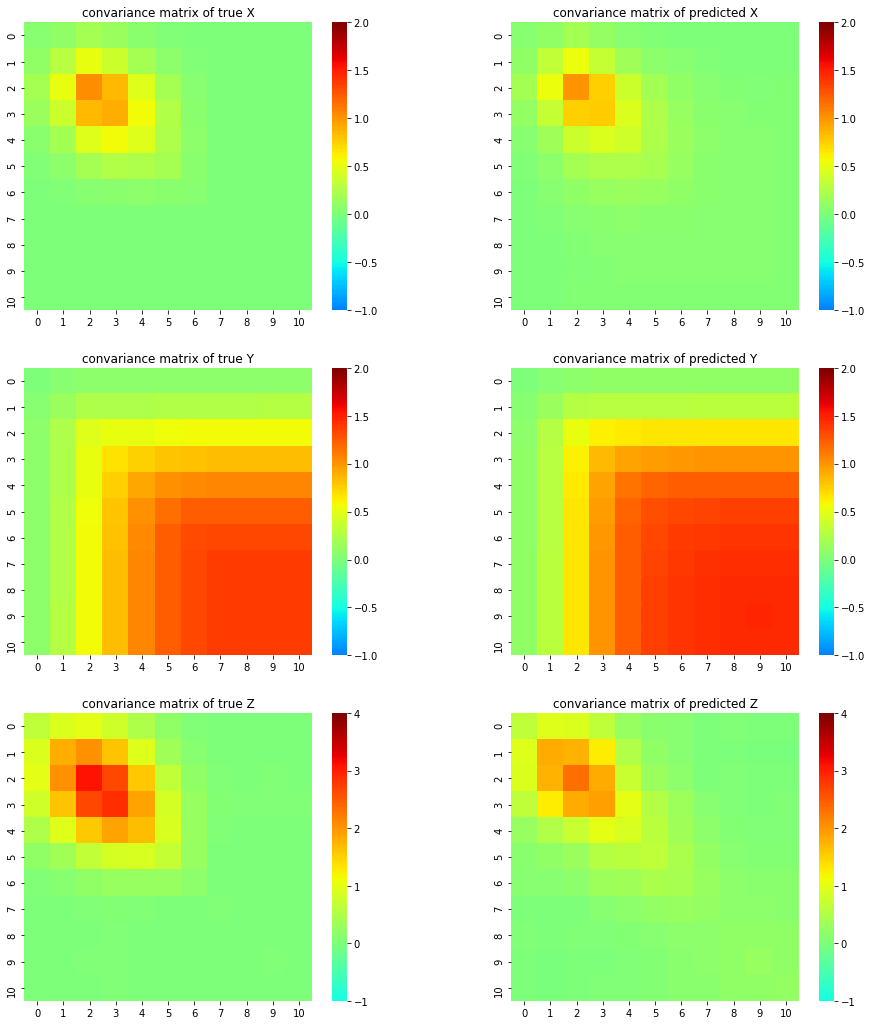

In [29]:
fig = plt.figure(figsize = (16,18))
axes = fig.add_subplot(3,2,1)
sns.heatmap(
    
    X_con_true, 
    vmin=-1, vmax=2, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    cmap = 'jet',
    square=True
)
axes.set_title('convariance matrix of true X')

axes = fig.add_subplot(3,2,2)
sns.heatmap(
    X_con_pred, 
    vmin=-1, vmax=2, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    cmap = 'jet',
    square=True
)
axes.set_title('convariance matrix of predicted X')

axes = fig.add_subplot(3,2,3)
sns.heatmap(
    Y_con_true, 
    vmin=-1, vmax=2, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    cmap = 'jet',
    square=True
)
axes.set_title('convariance matrix of true Y')


axes = fig.add_subplot(3,2,4)
sns.heatmap(
    Y_con_pred, 
    vmin=-1, vmax=2, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    cmap = 'jet',
    square=True
)
axes.set_title('convariance matrix of predicted Y')


axes = fig.add_subplot(3,2,5)
sns.heatmap(
    Z_con_true, 
    vmin=-1, vmax=4, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    cmap = 'jet',
    square=True
)
axes.set_title('convariance matrix of true Z')


axes = fig.add_subplot(3,2,6)
sns.heatmap(
    Z_con_pred, 
    vmin=-1, vmax=4, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    cmap = 'jet',
    square=True
)
axes.set_title('convariance matrix of predicted Z')
plt.show()
